In [400]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

In [401]:
DS1 = "csv/convert/capture1_1.csv"
DSMERGED = "csv/convert/capture_merge_1.csv"
LOG = "csv/conn.log.labeled"

# Datensatzauswahl

Welche Datensätze haben wir in betracht gezogen und warum haben wir uns für diesen entschieden?

# Vorstellung der .log files und deren Struktur 
### Beispielhaft für Datensatz 1

In [423]:
def read_log_file():
        fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
                'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label']
        df = pd.read_csv(LOG, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                        names=fieldsIN, header=None, engine='python', index_col=None)
        df = df.replace('-', np.nan)
        return df

In [422]:
df_raw_log = read_log_file()
pd.set_option('display.max_columns', None)
df_raw_log.head()

,ts,uid,orig_h,orig_p,resp_h,resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,NaN,2.998796,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CMBrup3BLXivSp4Avc,192.168.100.103,50244,120.210.108.200,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CfHl9r3XMYtDQRrHnh,192.168.100.103,34243,147.7.65.203,49560,tcp,NaN,2.998804,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Benign,NaN


### Spaltenübersicht

<div style="tposition>
    
| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |
</div>

In [424]:
df_raw_log.dtypes

ts                float64
uid                object
orig_h             object
orig_p              int64
resp_h             object
resp_p              int64
proto              object
service            object
duration           object
orig_bytes         object
resp_bytes         object
conn_state         object
local_orig        float64
local_resp        float64
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents     object
label              object
detailed-label     object
dtype: object

In [425]:
df_raw_log.isna().sum()

ts                      0
uid                     0
orig_h                  0
orig_p                  0
resp_h                  0
resp_p                  0
proto                   0
service           1005504
duration           796298
orig_bytes         796298
resp_bytes         796298
conn_state              0
local_orig        1008745
local_resp        1008745
missed_bytes            0
history             17421
orig_pkts               0
orig_ip_bytes           0
resp_pkts               0
resp_ip_bytes           0
tunnel_parents          0
label                   0
detailed-label     469274
dtype: int64

| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | -         |
| uid		        | UUID 			                    | -         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | -         |
| duration		    | Dauer 			                | -         |
| orig_bytes		| Ursprüngliche Bytes 		        | -         |
| resp_bytes		| Antwortbytes 			            | -         |
| conn_state		| Verbindungszustand 		        | -         |
| local_orig		| Lokal (Ursprung) 		            | -         |
| local_resp		| Lokal (Antwort) 		            | -         |
| missed_bytes	    | Verpasste Bytes 		            | -         |
| history		    | Historie 			                | -         |
| orig_pkts		    | Ursprüngliche Pakete 		        | -         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | -         |
| resp_pkts		    | Antwortpakete 			        | -         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | -         |
| tunnel_parents	| Tunnel-Eltern 			        | -         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | -         |


## Encoding der Spalten

In [427]:
protos = list(df_raw_log.proto.unique().flatten())
conn_states = list(df_raw_log.conn_state.unique().flatten())
histories = list(df_raw_log.history.unique().flatten())

def convert_ipv4(addr):
    """Konvertieren einer IPv4 Adresse zu einem INT"""
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def con_proto(proto):
    """Konvertieren der Ports ICMP, TCP und UDP zu einem INT"""
    return protos.index(proto)

def convert_connstate(state):
    return conn_states.index(state)

def convert_histories(history):
    return histories.index(history)
        

### Konvertieren des DataFrames in ein normiertes Format
1. Konvertieren der IPv4 Spalten
2. Konvertieren der Protokoll Spalte
3. Löschen der ts und uid spalten

In [428]:
def norm_df(df):
    """
    Normierung des DataFrames, dh löschen der Spalten, welche nicht gebraucht werden und konvertieren der object Spalten zu INT
    """
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    df['proto'] = df['proto'].apply(con_proto)
    df['conn_state'] = df['conn_state'].apply(convert_connstate)
    df['history'] = df['history'].apply(convert_histories)
    df = df.drop(['uid', 'ts', 'tunnel_parents', 'detailed-label', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp'], axis=1)
    df['label'] = (df['label'] == "Malicious").astype(int)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [429]:
df_conversion_1 = norm_df(df_raw_log)

In [430]:
df_conversion_1.dtypes

orig_h           int64
orig_p           int64
resp_h           int64
resp_p           int64
proto            int64
conn_state       int64
missed_bytes     int64
history          int64
orig_pkts        int64
orig_ip_bytes    int64
resp_pkts        int64
resp_ip_bytes    int64
label            int64
dtype: object

In [431]:
df_conversion_1.head(20)

,orig_h,orig_p,resp_h,resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,3232261223,41101,1864898353,23,0,0,0,0,1,60,0,0,1
1,3232261223,60905,2209273747,23,0,0,0,0,3,180,0,0,1
2,3232261223,44301,1529491263,23,0,0,0,0,1,60,0,0,1
3,3232261223,50244,2027056328,23,0,0,0,0,1,60,0,0,1
4,3232261223,34243,2466726347,49560,0,0,0,0,3,180,0,0,0
5,3232261223,34840,2443453190,21288,0,0,0,0,1,60,0,0,0
6,3232261223,58525,2974521213,23,0,0,0,0,1,60,0,0,1
7,3232261223,43849,1586579063,8080,0,0,0,0,1,60,0,0,1
8,3232261223,40973,1055900109,8080,0,0,0,0,1,60,0,0,1
9,3232261223,52259,3250416306,23,0,0,0,0,3,180,0,0,1


In [432]:
df_conversion_1.label.value_counts()

label
1    539471
0    469274
Name: count, dtype: int64

In [21]:
def viz(df):
    for c, label in enumerate(df.columns):
        counts, edges, bars = plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=True, stacked=True)
        counts2, edges2, bars2 = plt.hist(df[df["label"] ==  0][label], color='red', label='Benign', alpha=0.7, density=True, stacked=True)
        plt.title(label)
        plt.ylabel("probability density")
        plt.xlabel(label)
        plt.legend()
        plt.show()

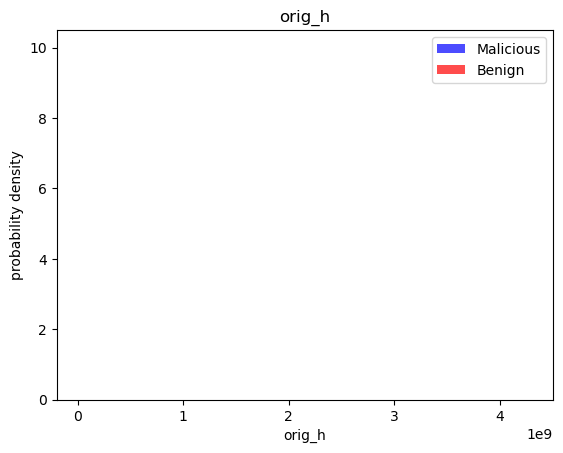

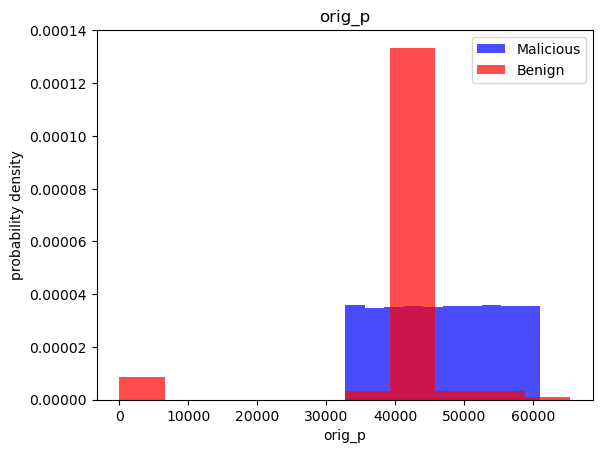

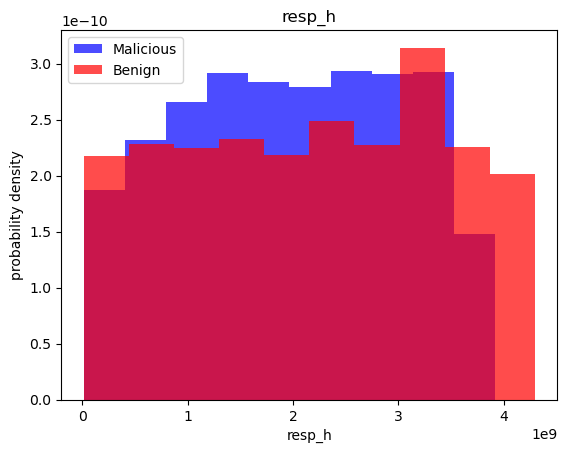

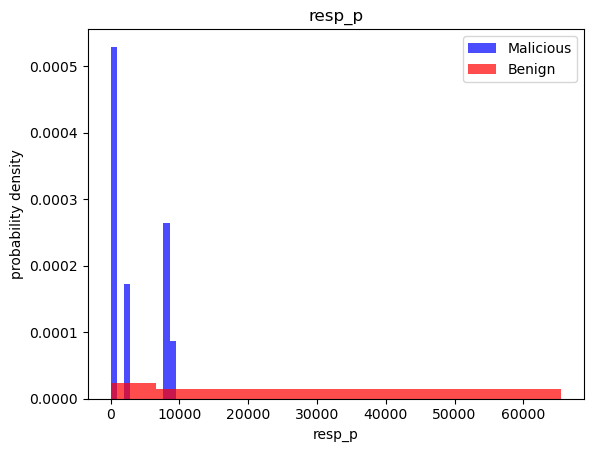

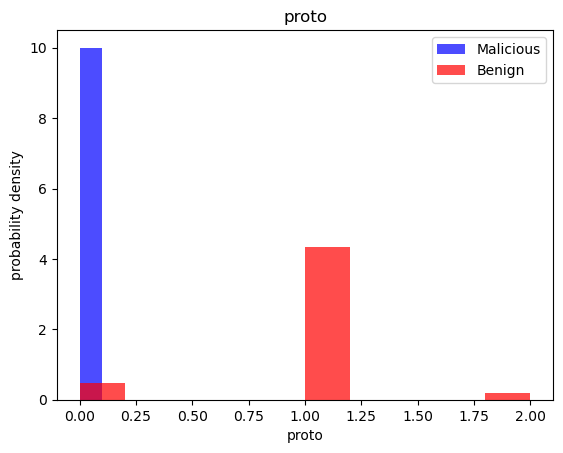

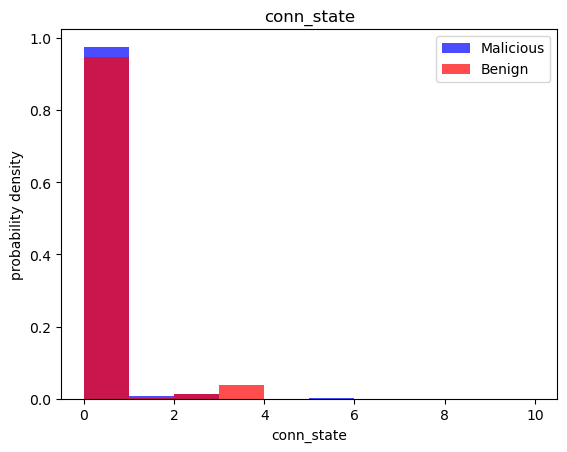

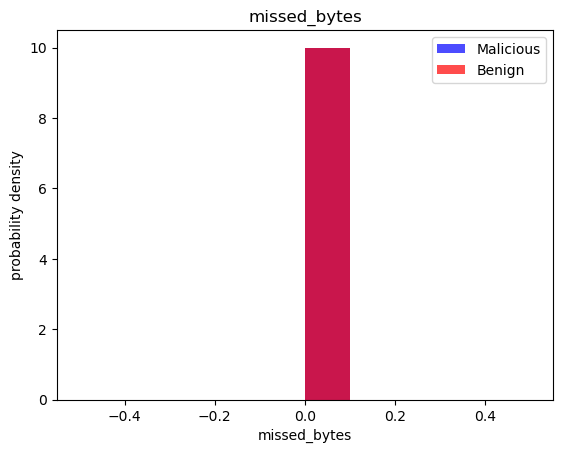

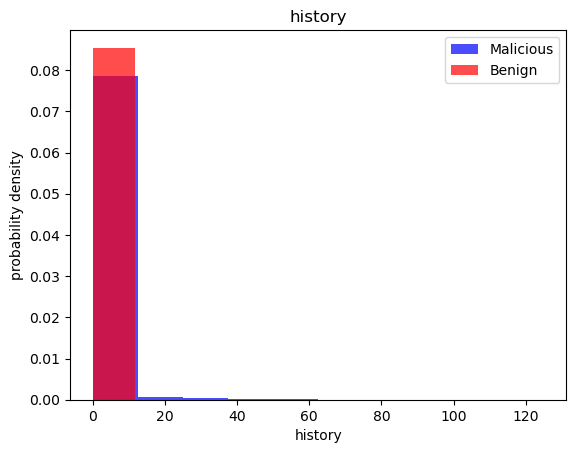

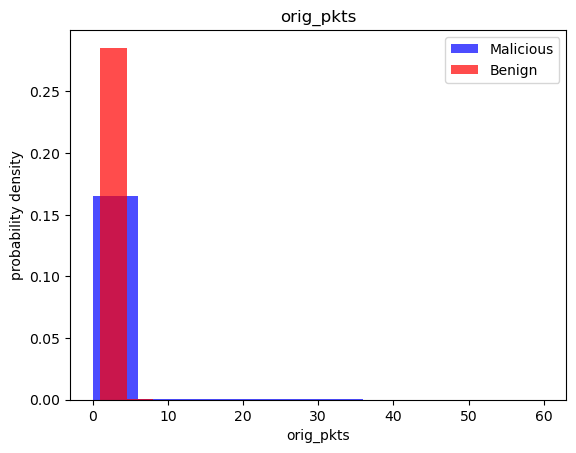

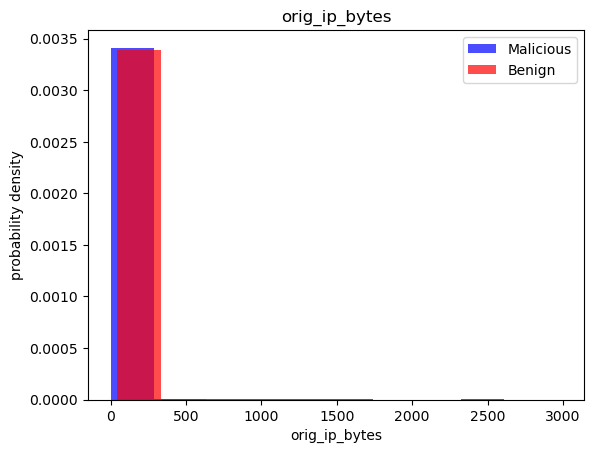

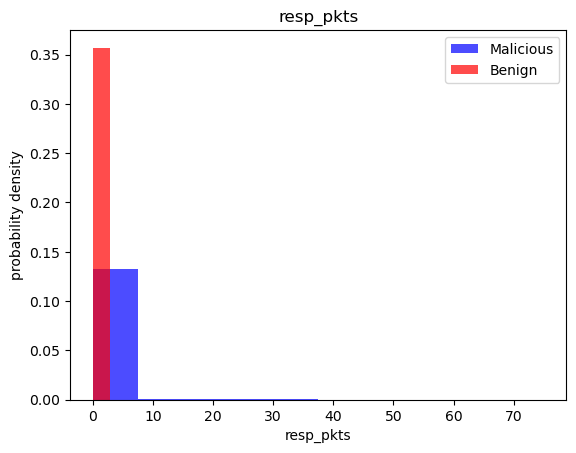

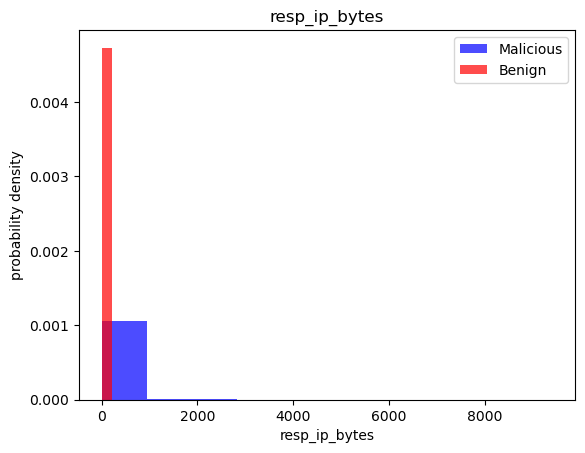

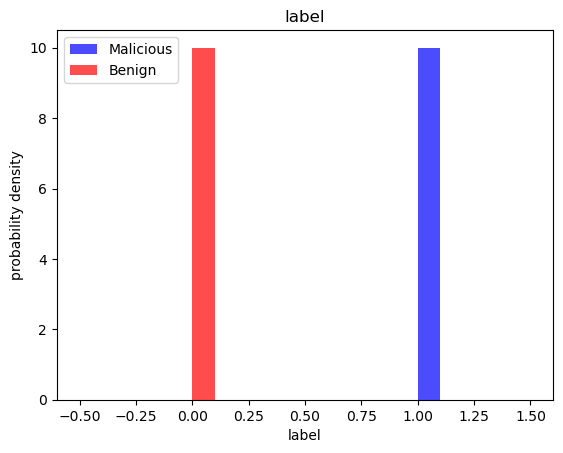

In [22]:
viz(df_conversion_1)

## Scatter plot der Daten

In [23]:
def make_bytes_plot(df) -> plt.figure:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='label', ax=ax1)
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='proto', ax=ax3)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='label', ax=ax2)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='proto', ax=ax4)
    plt.show()
    return fig

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


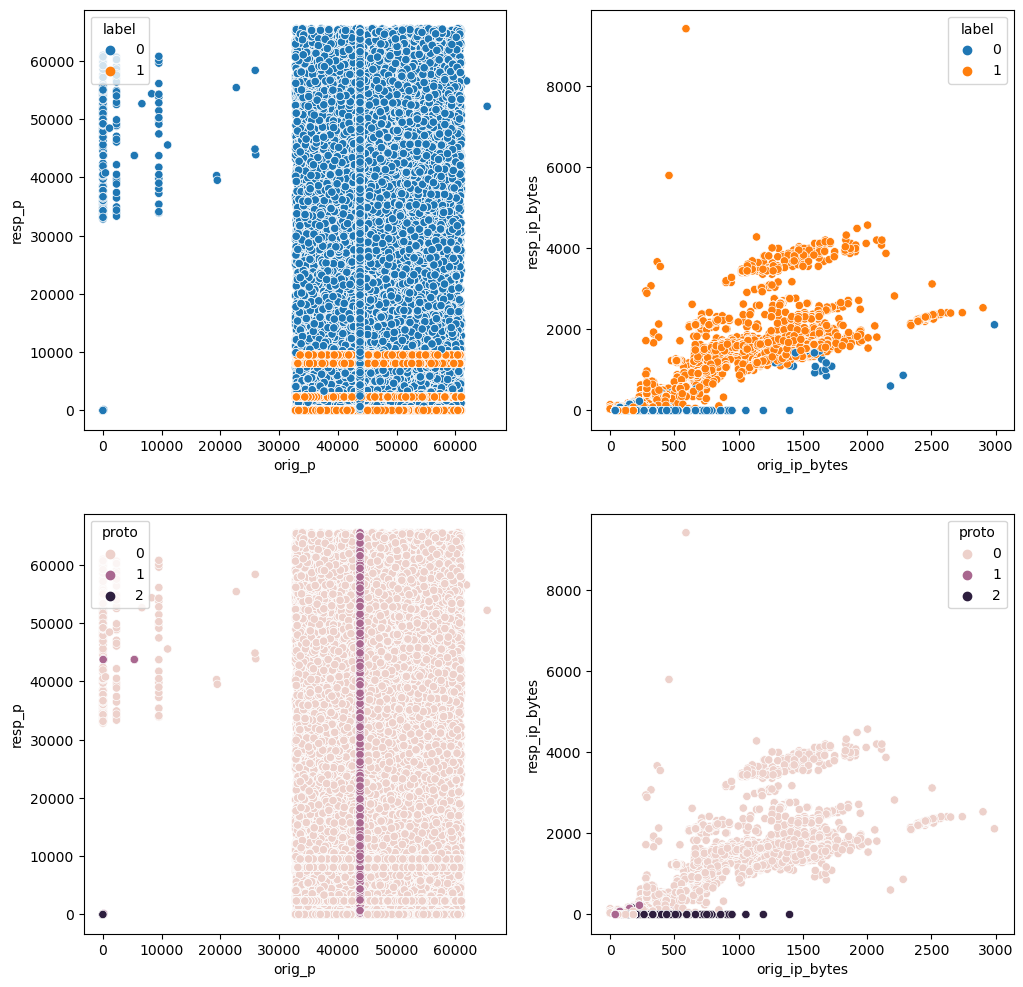

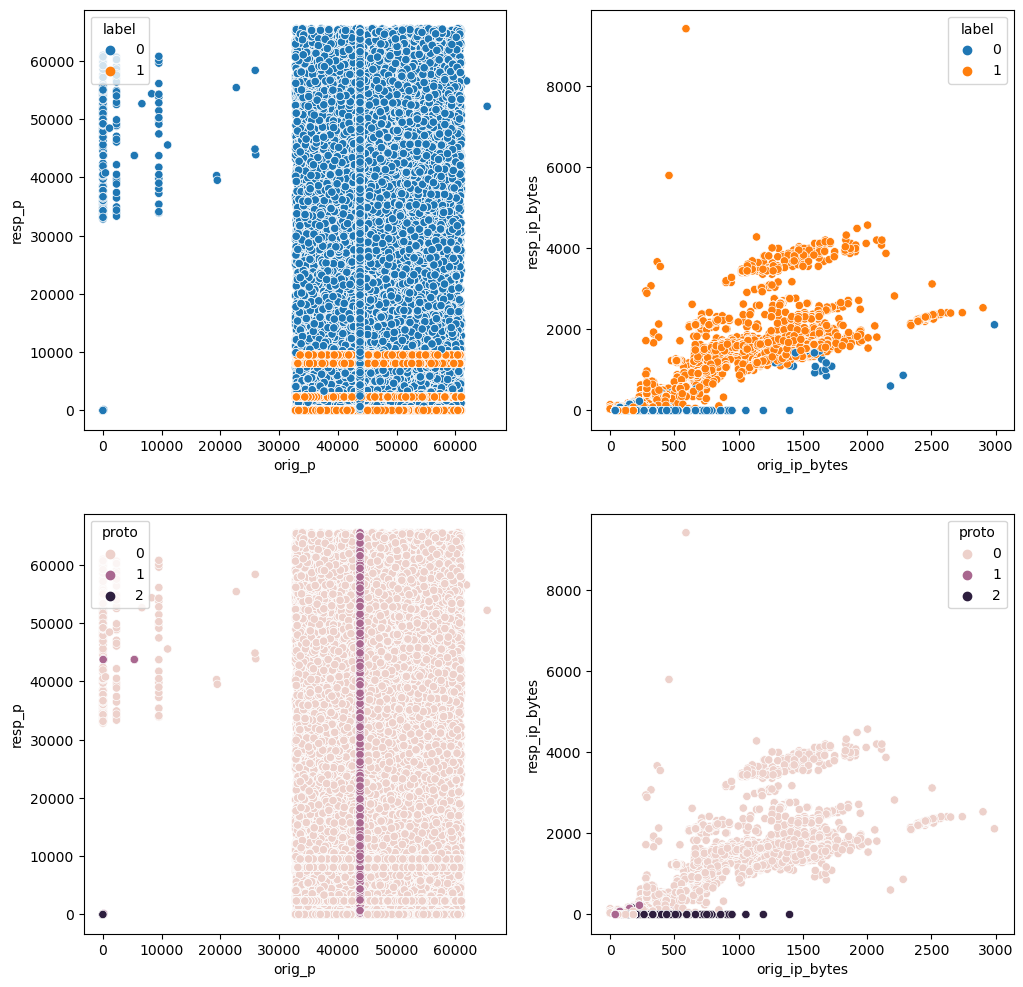

In [433]:
make_bytes_plot(df_conversion_1)

# Konvertierung eines .log files in eine CSV

In [276]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [26]:
df_ds1

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,59686,1159721954,8080,1,1
1,3232261223,43763,3663581508,47061,2,0
2,3232261223,51353,2712346730,2323,1,1
3,3232261223,43763,2028023405,39377,2,0
4,3232261223,45543,987512794,23,1,1
...,...,...,...,...,...,...
1008740,3232261223,44552,873217422,2323,1,1
1008741,3232261223,52111,3145280628,23,1,1
1008742,3232261223,56553,593749694,2323,1,1
1008743,3232261223,48087,716058614,8080,1,1


In [27]:
df_dsmerged

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,43763,3663581508,47061,2,0
1,3232261223,43763,2028023405,39377,2,0
2,3232261223,43763,2713856255,20457,2,0
3,3232261223,43763,1066870262,16504,2,0
4,3232261223,43763,3798348164,37327,2,0
...,...,...,...,...,...,...
2123247,3232235972,3372,908547944,992,1,1
2123248,3232235972,30751,3512843912,80,1,1
2123249,3232235972,16764,908547944,992,1,1
2123250,3232235972,4020,3512843912,80,1,1


---

# Mergen der dateien 1, 7, 35

In [434]:
def merge(datasets: list):
  df_return = pd.DataFrame()
  for d in datasets:
    df = pd.read_csv(f"csv/convert/capture{d}_1.csv")
    print(f"====\nDF{d}")
    print(f"shape before: {df.shape}")
    print(f"labels before:\n\t1:: {len(df[df['label'] == 1])}\n\t0:: {len(df[df['label'] == 0])}")
    l_dfs = [df[df['label'] == 0], df[df['label'] == 1]]
    for label in [0,1]:
      if len(l_dfs[label]) > 500_000:
        percent = 500_000 / len(l_dfs[label])
        print(f"cut {1-percent} off label == {label}")
        l_dfs[label] = np.array_split(l_dfs[label].sample(frac=1), 1/percent)[0]
    df = pd.concat(l_dfs, ignore_index=1)
    df_return = pd.DataFrame(pd.concat([df_return,df],ignore_index = True))
  print("=== now changing the df_return ===")
  ones = len(df_return[df_return['label'] == 1])
  zeros = len(df_return[df_return['label'] == 0])
  thebigger = 1 if ones > zeros else 0
  perc = zeros / ones
  print("shape before: ")
  print(df_return["label"].value_counts())
  print(f"ratio: {perc}")
  perc =  1 - perc if perc > 1 else perc
  print(f"cut_perc {perc}")
  l_dfs = [df_return[df_return['label'] == 0], df_return[df_return['label'] == 1]]
  rows_to_cut = int(len(l_dfs[thebigger]) * perc)
  l_dfs[thebigger] = l_dfs[thebigger].iloc[:rows_to_cut]
  df_return = pd.concat(l_dfs)
  print("===\nshape after: ")
  print(df_return["label"].value_counts())
  print(f"shape: {df_return.shape}")
  return df_return

In [435]:
ids = [1,7,35]
df = merge(ids)

====
DF1
shape before: (1008745, 7)
labels before:
	1:: 539471
	0:: 469274
cut 0.07316612014362223 off label == 1
====
DF7
shape before: (11454711, 7)
labels before:
	1:: 11378759
	0:: 75952
cut 0.95605847702724 off label == 1
====
DF35
shape before: (10447784, 7)
labels before:
	1:: 2185396
	0:: 8262388
cut 0.9394848075399025 off label == 0
cut 0.7712085132397057 off label == 1
=== now changing the df_return ===
shape before: 
label
1    1603037
0    1061626
Name: count, dtype: int64
ratio: 0.6622591992574095
cut_perc 0.6622591992574095
===
shape after: 
label
0    1061626
1    1061626
Name: count, dtype: int64
shape: (2123252, 7)


---

# Training der Datensätze

## Split in Test-, Validierung- und Trainingsdatensatz, Oversampling

In [436]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler

In [437]:
def split(df):
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [438]:
X = pd.DataFrame()
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [439]:
train, valid, test = split(df_dsmerged) # Hier umstellen df_ds1 oder df_dsmerged
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

## Datensatz 1

### kNN

In [272]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#### kNN - K-Optimierung


In [273]:
k_range=range(1,10)
knn_r_acc = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance', metric='euclidean')
    knn.fit(X_train,y_train)

    train_score = knn.score(X_train,y_train)
    test_score = knn.score(X_test,y_test)
    vaild_score = knn.score(X_valid,y_valid)

    knn_r_acc.append((k, train_score,test_score, vaild_score))

    print(f"finished {k}")

df = pd.DataFrame(knn_r_acc, columns=['K','Train Score', 'Test Score','Vaild Score'])
print(df)

finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
   K  Train Score  Test Score  Vaild Score
0  1          1.0    0.998592     0.998657
1  2          1.0    0.998592     0.998657
2  3          1.0    0.998131     0.998414
3  4          1.0    0.997928     0.998151
4  5          1.0    0.997626     0.997963
5  6          1.0    0.997358     0.997784
6  7          1.0    0.997026     0.997626
7  8          1.0    0.996823     0.997373
8  9          1.0    0.996634     0.997105


#### kNN - Endergebnis

In [274]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree',  weights='distance', metric='euclidean')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94078
           1       1.00      1.00      1.00    107671

    accuracy                           1.00    201749
   macro avg       1.00      1.00      1.00    201749
weighted avg       1.00      1.00      1.00    201749



### dTrees

In [440]:
# Imports
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [441]:
# capture1_1.csv
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True)
valid, X_valid, y_valid = scale(valid, False)
test, X_test, y_test = scale(test, False)

In [442]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier(ccp_alpha=0.1, max_depth=4, random_state=1)

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

{'ccp_alpha': 0.1,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

### ANN

In [443]:
import tensorflow as tf

2023-08-01 21:35:04.743992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 21:35:05.037359: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 21:35:05.038783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 21:35:06.856787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [444]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()

In [445]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes <= 128, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(5,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


32 nodes, dropout_prob 0, lr 0.001, batch size 64


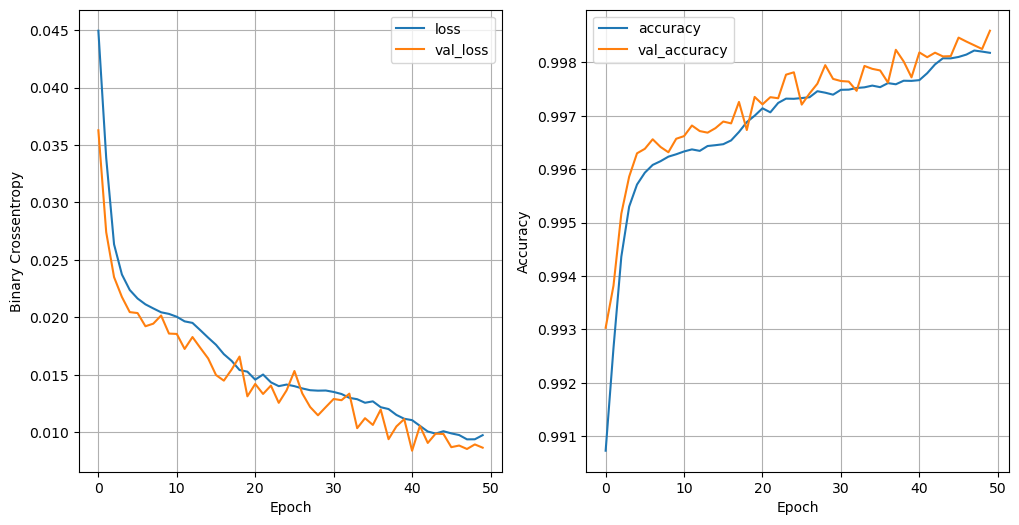

6305/6305 [==============================] - 9s 1ms/step - loss: 0.0078 - accuracy: 0.9985


In [446]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
for nodes in [32]:
    for dropout_prob in [0]:
        for lr in [0.001]:
            for batch_size in [64]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_test, y_test)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

## Zusammengesetzer Datensatz (merged) 

### kNN

In [278]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [451]:
X = df_dsmerged.drop('label',axis=1)
y = df_dsmerged.label

#### Hyperparameter Optimierung n_neighbors kNN

In [452]:
from sklearn.model_selection import GridSearchCV

grid_params = {
'n_neighbors': [1,2,3,4,5,6],
'weights': ['uniform', 'distance'],
'metric': ['euclidean', 'manhattan'],
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 0,
    cv = 3,     # Determines the cross-validation splitting strategy
                # integer, to specify the number of folds
    #n_jobs = -1 # use all processors to perform the model
)

gs_results = gs.fit(X, y)

In [281]:
gs_results.best_score_

0.8986799842095562

In [282]:
gs_results.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [283]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

#### kNN - Plot Results

In [284]:
def plot_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

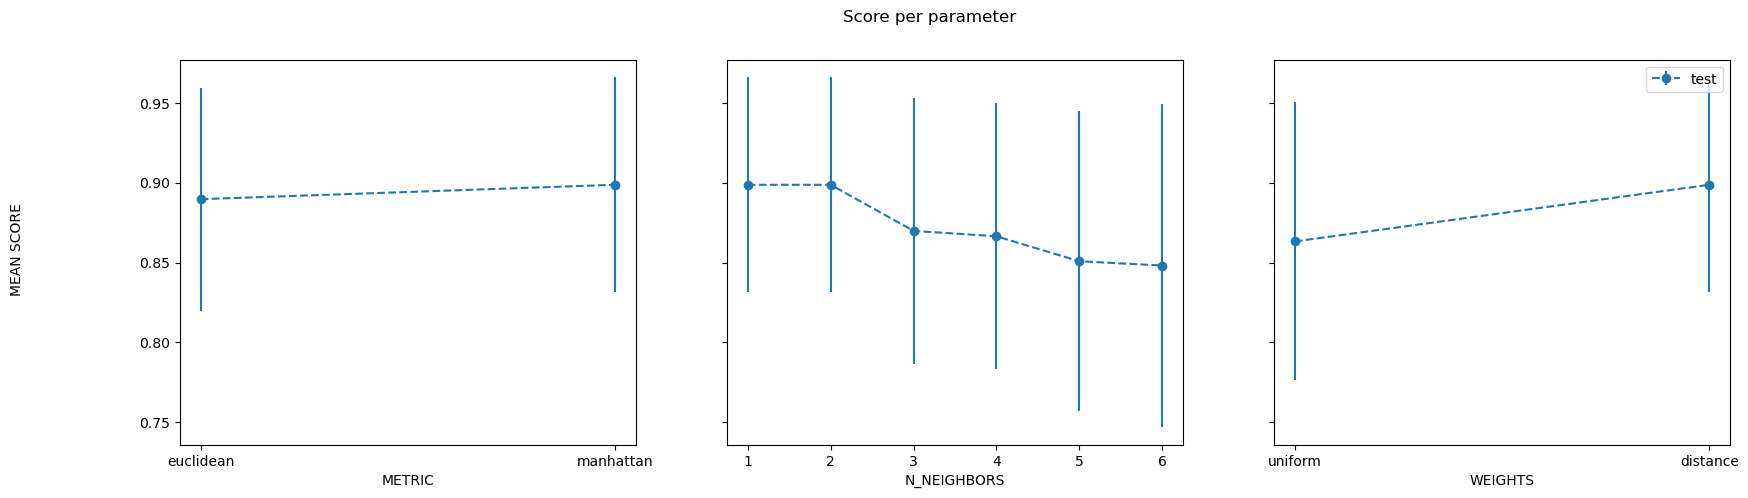

In [285]:
plot_search_results(gs_results)

#### kNN - Endergebnis

In [286]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan',weights='distance')
knn.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [287]:
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))
print(knn.score(X_valid,y_valid))

1.0
0.9150620156316599
0.9008595313787825


In [ ]:
y_pred = knn.predict(X_valid)
print(classification_report(y_valid, y_pred))

### DTrees

In [449]:
# capture_merge_1.csv
train, valid, test = split(df_dsmerged)
train, X_train, y_train = scale(train, True)
valid, X_valid, y_valid = scale(valid, False)
test, X_test, y_test = scale(test, False)

In [333]:
X_train

array([[ 0.06331016, -1.53900685, -0.93826618,  1.07688758, -0.48944156],
       [ 0.06331013,  1.34441107,  1.18898561, -0.37660893, -0.48944156],
       [ 0.06331013,  1.27720779, -1.35581109, -0.45256997, -0.48944156],
       ...,
       [ 0.06331013,  1.02725966, -0.223734  , -0.87552654, -0.48944156],
       [ 0.06331013,  1.09195457, -0.70936042, -0.87552654, -0.48944156],
       [ 0.06331013,  0.08970595,  0.36142316, -0.87552654, -0.48944156]])

In [334]:
df_ds1.columns
X_train[0]

array([ 0.06331016, -1.53900685, -0.93826618,  1.07688758, -0.48944156])

#### DTrees - Hyperparameter Tuning

In [465]:
# Try ccp_alpha values
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=4, random_state=1, criterion= "gini", ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 11 with ccp_alpha: 0.0008575717287492415


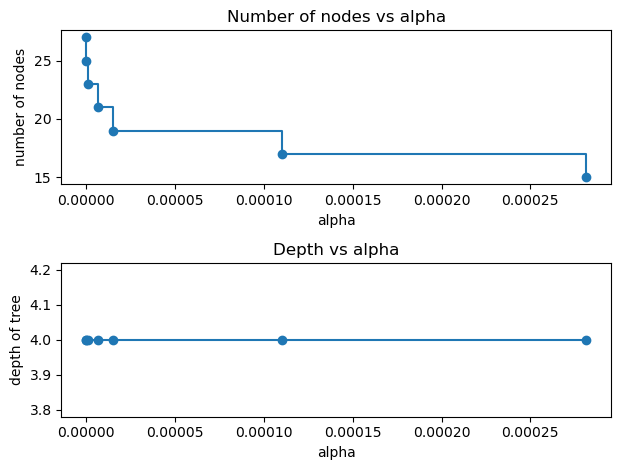

In [466]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.savefig('img/accuracy_alpha.png')

In [ ]:
# GridSearchCV function
from sklearn.model_selection import GridSearchCV

def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'max_depth': [1,2,3,4],'random_state': [None,1,2], 'criterion': ['entropy', 'gini']}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, n_jobs=30)
    #fit model to data
    dtree_gscv.fit(X, y)
    # print bets score achieved
    print(dtree_gscv.best_score_)

    return dtree_gscv.best_params_

In [459]:
X = df_ds1.copy()
y = X.label
X = X.drop(['label'], axis=1)

dtree_grid_search(X, y, 3)

0.9935989770664833


{'criterion': 'gini', 'max_depth': 4, 'random_state': None}

#### DTrees - Create and train tree

In [393]:
# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier(ccp_alpha=0.1, max_depth=4, random_state=1)

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

{'ccp_alpha': 0.1,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [394]:
# show difference between tree that doesn't have stopping criteria and the one that does
dtree.predict_proba(X_valid)

array([[0.99056731, 0.00943269],
       [0.04392955, 0.95607045],
       [0.99626998, 0.00373002],
       ...,
       [0.99626998, 0.00373002],
       [0.04392955, 0.95607045],
       [0.04392955, 0.95607045]])

In [395]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)

0.9732933003650065

In [396]:
# Percision
from sklearn.metrics import precision_score
precision_score(y_valid, y_pred)

0.9548720454627719

In [397]:
# Recall from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# true positives and false negatives
from sklearn.metrics import recall_score
recall_score(y_valid, y_pred)

0.9935643028308593

In [398]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.99      0.95      0.97    212241
   malicious       0.95      0.99      0.97    212409

    accuracy                           0.97    424650
   macro avg       0.97      0.97      0.97    424650
weighted avg       0.97      0.97      0.97    424650



#### DTrees - Feature importances

In [365]:
df_ds1_drop = df_ds1.drop(['label'], axis=1)
feature_names = df_ds1_drop.columns
feature_names

Index(['orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto'], dtype='object')

In [366]:
dtree.feature_importances_

array([0.36611892, 0.        , 0.        , 0.        , 0.63388108])

In [367]:
feature_importance = pd.DataFrame(dtree.feature_importances_, index = feature_names).sort_values(0, ascending=False)
feature_importance

,0
proto,0.633881
orig_h,0.366119
orig_p,0.000000
resp_h,0.000000
resp_p,0.000000


In [368]:
features = list(feature_importance[feature_importance[0]>0].index)
features

['proto', 'orig_h']

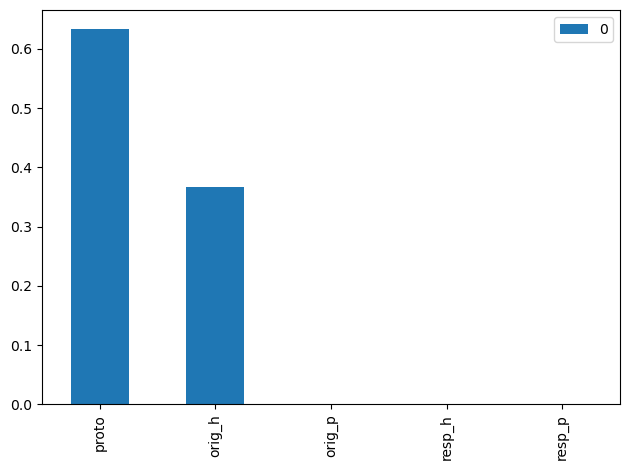

In [369]:
# feature plot
feature_importance.head(10).plot(kind='bar')
plt.tight_layout()
plt.savefig('img/feature.png')

#### DTrees - Tree plotting

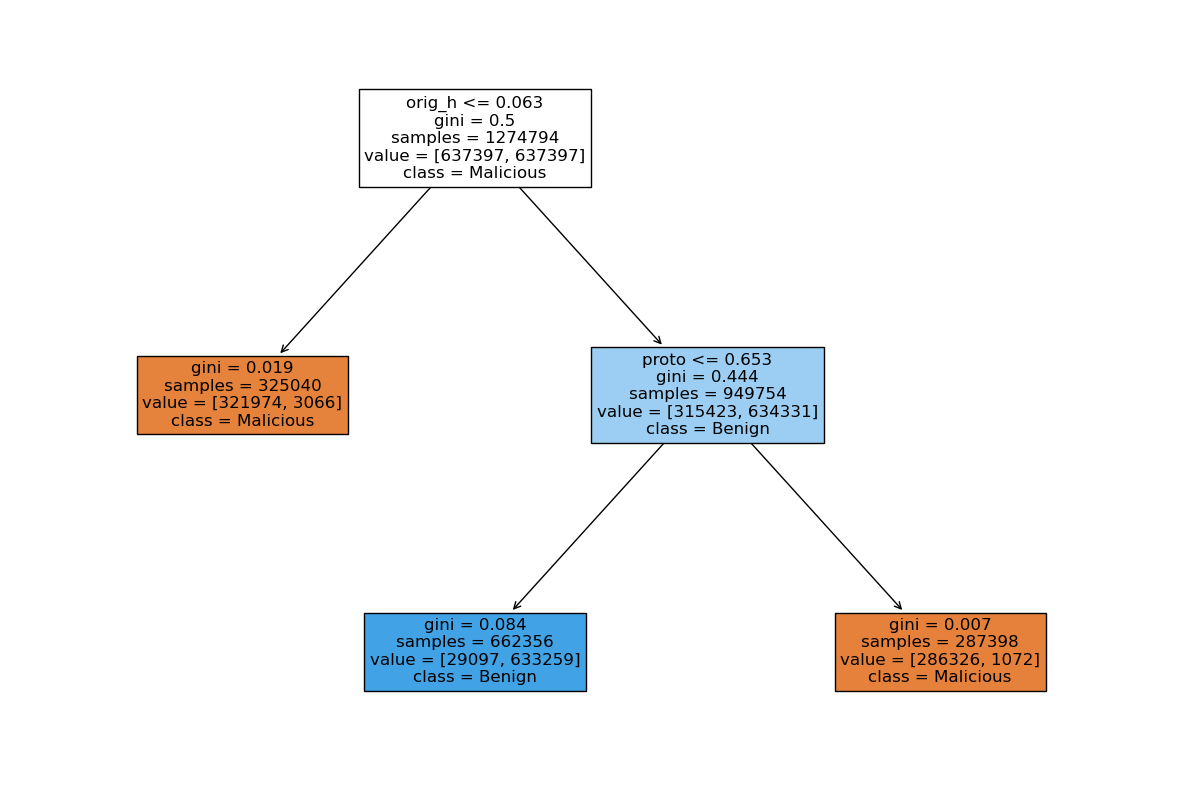

In [399]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dtree, 
                   feature_names=feature_names,  
                   class_names={0:'Malicious', 1:'Benign'},
                   filled=True,
                  fontsize=12)
plt.savefig('img/dtree.png')

In [372]:
import joblib

filename = "dtree_merged.joblib"

# save model
joblib.dump(dtree, filename)

['dtree_merged.joblib']

In [291]:
# load model
loaded_model = joblib.load(filename)

# you can use loaded model to compute predictions
y_pred = loaded_model.predict(X_valid)
y_pred

accuracy_score(y_valid, y_pred)

0.8477828800188391

### ANN

64 nodes, dropout_prob 0, lr 0.001, batch size 64


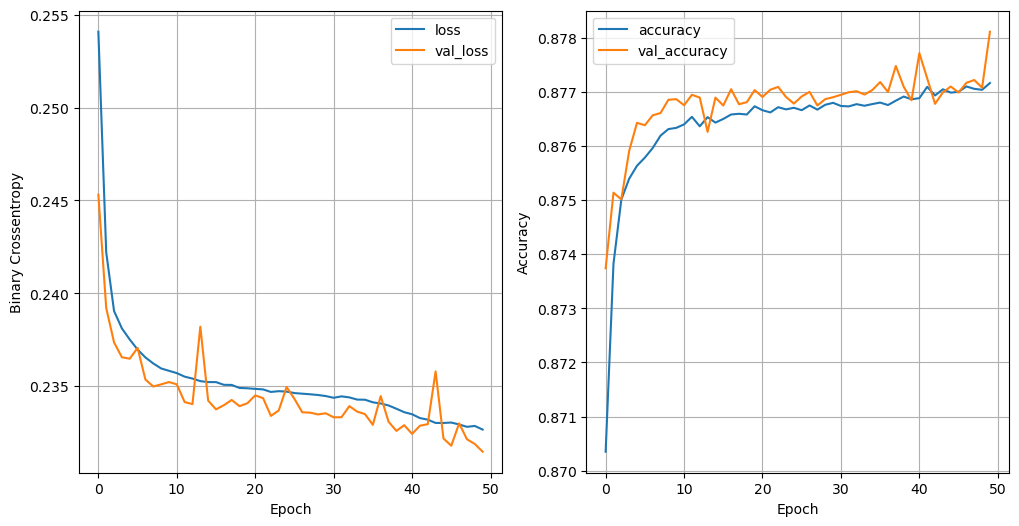

13271/13271 [==============================] - 18s 1ms/step - loss: 0.2325 - accuracy: 0.8778


In [450]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
for nodes in [64]:
    for dropout_prob in [0]:
        for lr in [0.001]:
            for batch_size in [64]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_test, y_test)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
